In [72]:
# from google.colab import drive
# drive.mount('/content/drive')

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import warnings
warnings.filterwarnings("ignore")

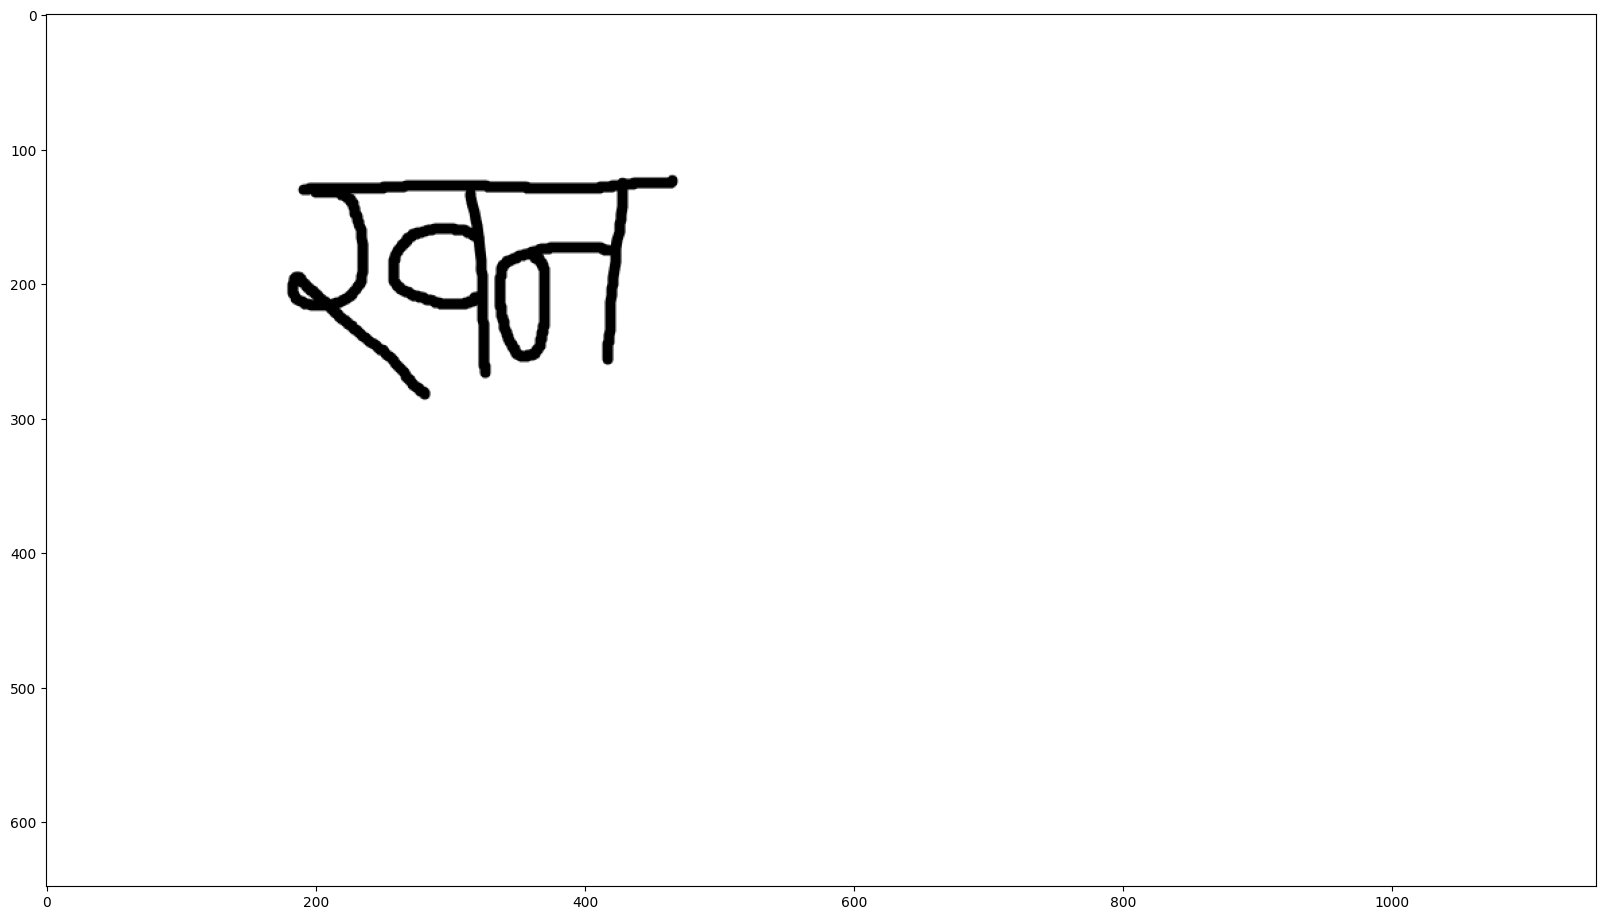

In [74]:


# img = cv2.imread("/content/drive/MyDrive/nepali_ocr/kara.png", 0)
# img = cv2.imread('good_pics/gajala.png', 0)
img = cv2.imread('good_pics/khana.png', 0)
# img = cv2.imread('kamala.png', 0)
def show(img, figsize=(20, 20)):
    fig = plt.figure(figsize=figsize)
    plt.imshow(img, cmap="gray")
    plt.show()
show(img)

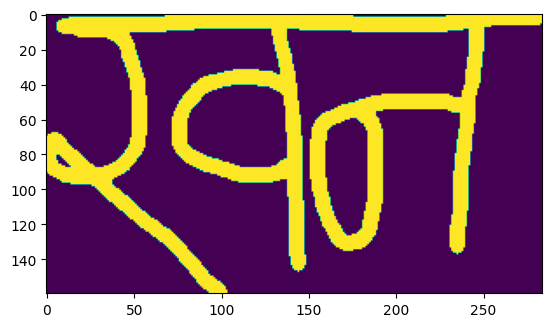

In [75]:
def borders(here_img, thresh, bthresh=0.092):
    shape = here_img.shape
    #check = int(115 * size[0] / 600)
    #check = int(55 * size[0] / 600)
    check= int(bthresh*shape[0])
    image = here_img[:]
    top, bottom = 0, shape[0] - 1
    #plt.imshow(image)
    #plt.show()

    #find the background color for empty column
    bg = np.repeat(thresh, shape[1])
    count = 0
    for row in range(1, shape[0]):
        if  (np.equal(bg, image[row]).any()) == True:
            #print(count)
            count += 1
        else:
            count = 0
        if count >= check:
            top = row - check
            break

    bg = np.repeat(thresh, shape[1])
    count = 0
    rows = np.arange(1, shape[0])
    #print(rows)
    for row in rows[::-1]:
        if  (np.equal(bg, image[row]).any()) == True:
            count += 1
        else:
            count = 0
        if count >= check:
            bottom = row + count
            break

    d1 = (top - 2) >= 0 
    d2 = (bottom + 2) < shape[0]
    d = d1 and d2
    if(d):
        b = 2
    else:
        b = 0

    return (top, bottom, b)

def preprocess(bgr_img):#gray image   
    blur = cv2.GaussianBlur(bgr_img,(5,5),0)
    ret,th_img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) #converts black to white and inverse

    rows, cols = th_img.shape
    bg_test = np.array([th_img[i][i] for i in range(5)])
    if bg_test.all() == 0:
        text_color = 255
    else:
        text_color = 0

    tb = borders(th_img, text_color)
    lr = borders(th_img.T, text_color)
    dummy = int(np.average((tb[2], lr[2]))) + 2
    template = th_img[tb[0]+dummy:tb[1]-dummy, lr[0]+dummy:lr[1]-dummy]

    plt.imshow(template)
    plt.show()
    return (template, tb, lr)
prepimg, tb, lr = preprocess(img)

(160, 284)
segment shape:  (160, 150)


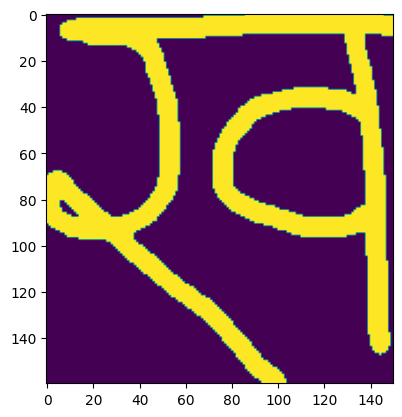

segment shape:  (160, 133)


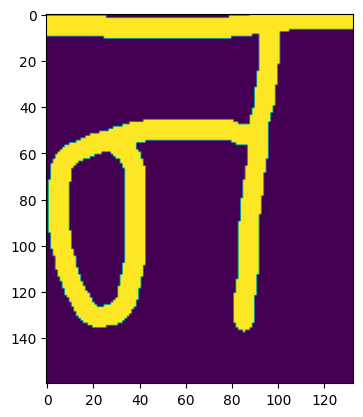

In [76]:
def segmentation(bordered, thresh=255, min_seg=10, scheck=0.15):
    try:
        shape = bordered.shape
        check = int(scheck * shape[0])
        image = bordered[:]
        image = image[check:].T
        shape = image.shape
        #plt.imshow(image)
        #plt.show()

        #find the background color for empty column
        bg = np.repeat(255 - thresh, shape[1])
        bg_keys = []
        for row in range(1, shape[0]):
            if  (np.equal(bg, image[row]).all()):
                bg_keys.append(row)            

        lenkeys = len(bg_keys)-1
        new_keys = [bg_keys[1], bg_keys[-1]]
        #print(lenkeys)
        for i in range(1, lenkeys):
            if (bg_keys[i+1] - bg_keys[i]) > check:
                new_keys.append(bg_keys[i])
                #print(i)

        new_keys = sorted(new_keys)
        #print(new_keys)
        segmented_templates = []
        first = 0
        bounding_boxes = []
        for key in new_keys[1:]:
            segment = bordered.T[first:key]
            if segment.shape[0]>=min_seg and segment.shape[1]>=min_seg:
                segmented_templates.append(segment.T)
                bounding_boxes.append((first, key))
            first = key

        last_segment = bordered.T[new_keys[-1]:]
        if last_segment.shape[0]>=min_seg and last_segment.shape[1]>=min_seg:
            segmented_templates.append(last_segment.T)
            bounding_boxes.append((new_keys[-1], new_keys[-1]+last_segment.shape[0]))

        return(segmented_templates, bounding_boxes)
    except:
        return [bordered, (0, bordered.shape[1])]
    
print(prepimg.shape)
segments=segmentation(prepimg)
for simg in segments[0]:
    print("segment shape: ", simg.shape)
    plt.imshow(simg)
    plt.show()


[(114, 292, 178, 328), (114, 292, 328, 461)]


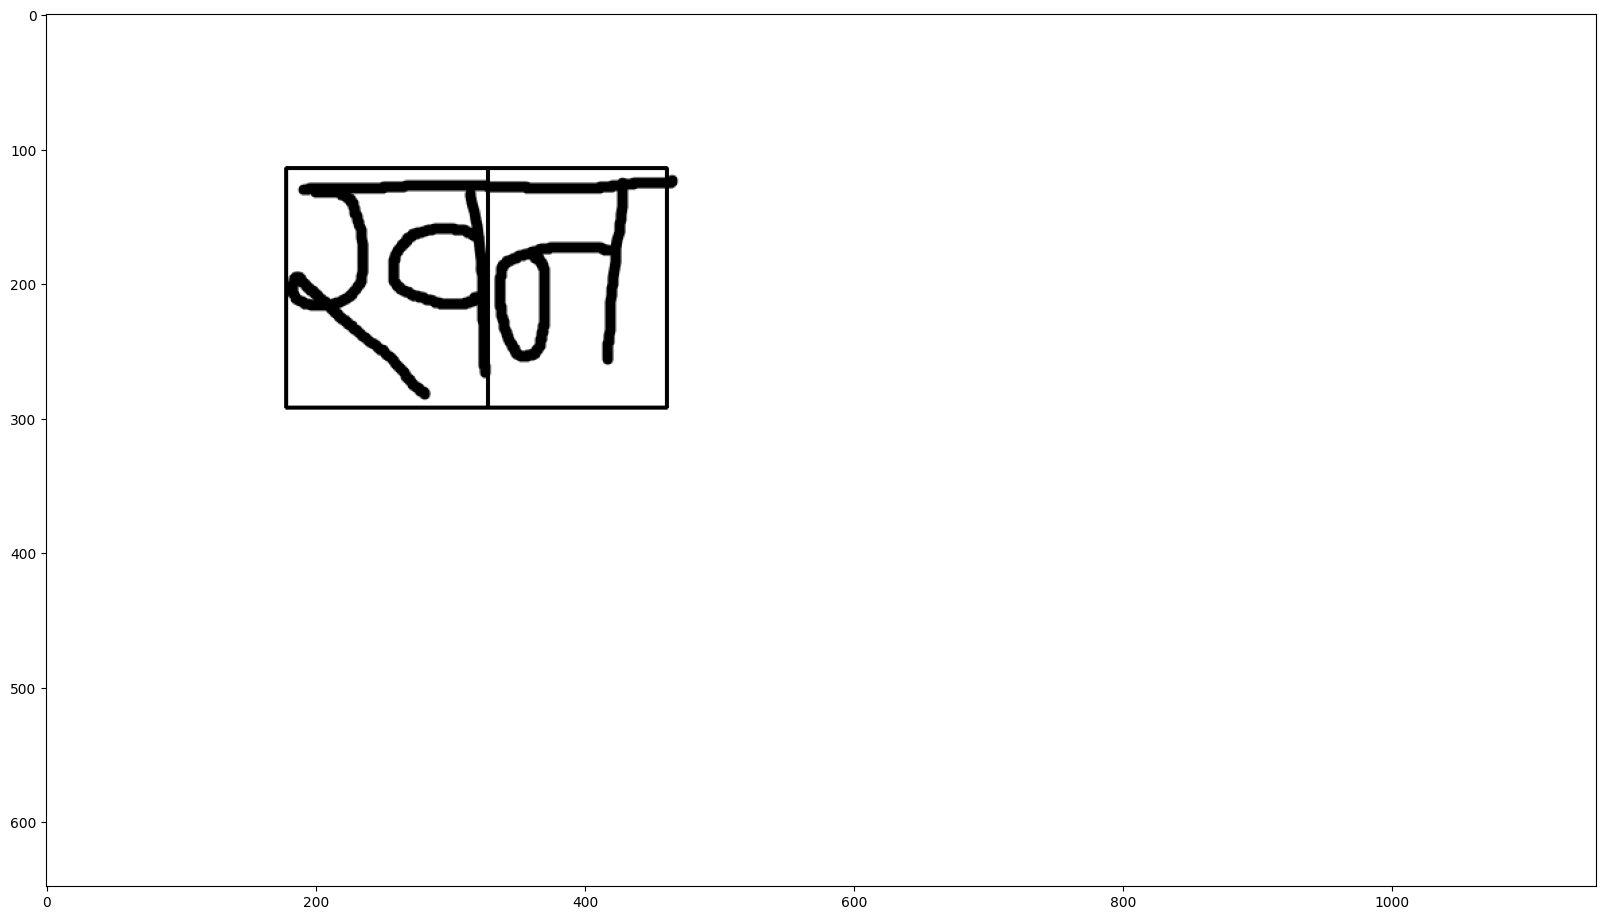

In [77]:
def localize(orig_img, tb, lr, segments):
    d=5
    rimg = orig_img.copy()
    boxes = []
    for simg, bb in zip(segments[0], segments[1]):
        bb = np.array(bb)
        bb += lr[0]
        # draw rows
        rimg[tb[0]-d:tb[0], bb[0]-d:bb[1]+d] = 0
        rimg[tb[1]:tb[1]+d, bb[0]-d:bb[1]+d] = 0

        # draw cols
        rimg[tb[0]-d:tb[1]+d, bb[0]-d:bb[0]+d] = 0
        rimg[tb[0]-d:tb[1]+d, bb[1]-d:bb[1]+d] = 0

        boxes.append((tb[0]-d, tb[1]+d, bb[0], bb[1]))
        #show(rimg)
    rimg = img.copy()
    print(boxes)
    for box in boxes:
        t, b, l, r = box
        cv2.rectangle(rimg, (l, t), (r, b), (0, 0, 0), 2)
    show(rimg)    
    return rimg, boxes
localized = localize(img, tb, lr, segments)

In [78]:
# def localize_characters(orig_img, tb, lr, segments):
#     d=5
#     rimg = orig_img.copy()
#     boxes = []
#     for simg, bb in zip(segments[0], segments[1]):
#         bb = np.array(bb)
#         bb += lr[0]
#         # draw rows
#         rimg[tb[0]-d:tb[0], bb[0]-d:bb[1]+d] = 0
#         rimg[tb[1]:tb[1]+d, bb[0]-d:bb[1]+d] = 0

#         # draw cols
#         rimg[tb[0]-d:tb[1]+d, bb[0]-d:bb[0]+d] = 0
#         rimg[tb[0]-d:tb[1]+d, bb[1]-d:bb[1]+d] = 0

#         boxes.append((tb[0]-d, tb[1]+d, bb[0], bb[1]))
#         #show(rimg)
#     rimg = img.copy()
#     print(boxes)
#     for box in boxes:
#         t, b, l, r = box
#         cv2.rectangle(rimg, (l, t), (r, b), (0, 0, 0), 2)
#     show(rimg)
#     return rimg, boxes


# original_image = cv2.imread("/content/drive/MyDrive/nepali_ocr/kara.png", cv2.IMREAD_GRAYSCALE)
# localized = localize_characters(original_image, )


In [79]:
import tensorflow as tf

loaded_model = tf.keras.models.load_model("new_best_weights.h5")

In [80]:


# classes = ['character_10_yna', 'character_11_taamatar', 'character_12_thaa', 'character_13_daa', 'character_14_dhaa', 'character_15_adna', 'character_16_tabala', 'character_17_tha', 'character_18_da', 'character_19_dha', 'character_1_ka', 'character_20_na', 'character_21_pa', 'character_22_pha', 'character_23_ba', 'character_24_bha', 'character_25_ma', 'character_26_yaw', 'character_27_ra', 'character_28_la', 'character_29_waw', 'character_2_kha', 'character_30_motosaw', 'character_31_petchiryakha', 'character_32_patalosaw', 'character_33_ha', 'character_34_chhya', 'character_35_tra', 'character_36_gya', 'character_3_ga', 'character_4_gha', 'character_5_kna', 'character_6_cha', 'character_7_chha', 'character_8_ja', 'character_9_jha', 'digit_0', 'digit_1', 'digit_2', 'digit_3', 'digit_4', 'digit_5', 'digit_6', 'digit_7']


# def prediction(img):
#     characters = '०,१,२,३,४,५,६,७,८,९,क,ख,ग,घ,ङ,च,छ,ज,झ,ञ,ट,ठ,ड,ढ,ण,त,थ,द,ध,न,प,फ,ब,भ,म,य,र,ल,व,श,ष,स,ह,क्ष,त्र,ज्ञ'
#     characters = characters.split(',')


#     x = np.asarray(img, dtype = np.float32).reshape(1, 32, 32, 1) / 255

#     output = loaded_model.predict(x)
#     # print(output.shape, output)
#     output = output.reshape(46)
#     predicted = np.argmax(output)
#     devanagari_label = characters[predicted]
#     print(classes[predicted])
#     success = output[predicted] * 100

#     return devanagari_label, success

In [81]:
def prediction(img):
    # characters = ['य', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'क', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'ख', 'श', 'ष', 'स', 'ह', 'छ', 'त्र', 'ज्ञ', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', '०', '१', '२', '३', '४', '५', '६', '७']
    characters = ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '5', '6', '7', '8', '9']

    devanagari_characters = [
        '०', '१', '२', '३', '४', '५', '६', '७', '८', '९',
        'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 
        'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'क्ष', 'त्र', 'ज्ञ'
    ]
    loaded_model = tf.keras.models.load_model("new_best_weights.h5")
    x = np.asarray(img, dtype = np.float32).reshape(1, 32, 32, 1) / 255 

    output = loaded_model.predict(x)
    output = output.reshape(46)
    predicted = np.argmax(output)
    devanagari_label = characters[predicted]
    devanagari_character = devanagari_characters[int(devanagari_label)]
    print(devanagari_character)
    success = output[predicted] * 100

    return devanagari_character, success

In [82]:
def classifier(segments):
    pred_lbl = ""
    acc = []
    for segment in segments:
        segment = cv2.resize(segment, (32, 32))
        segment = cv2.GaussianBlur(segment, (3, 3), 0)
        segment = cv2.erode(segment, (3, 3), 1)
        #show(segment)

        lbl, a = prediction(segment)
        pred_lbl+=lbl
        acc.append(a)
    return pred_lbl, np.array(acc).mean()
classifier(segments[0])


1/1 [==============================] - 0s 91ms/step
ख
1/1 [==============================] - 0s 66ms/step
ग


('खग', 65.98552167415619)

In [83]:
# `image_path = input(str("enter the path to the image"))
# print(image_path)
# image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# plt.imshow(image, cmap='gray')
# plt.axis('off')
# plt.show()
# image = cv2.resize(image, (32,32))
# print(prediction(preprocess(image)))`

In [84]:
# def classifier(segments):
#     # pred_lbl = ""
#     pred_lbl = []
#     acc = []
#     for segment in segments:
#         segment = cv2.resize(segment, (32, 32))
#         segment = cv2.GaussianBlur(segment, (3, 3), 0)
#         segment = cv2.erode(segment, (3, 3), 1)
#         #show(segment)

#         lbl, a = prediction(segment)
#         # pred_lbl+=lbl
#         pred_lbl.append(lbl)
#         acc.append(a)
#     return pred_lbl, np.array(acc).mean()
# image_path = "papa.jpg"
# image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# plt.imshow(gray_image, cmap="gray")
# preprocessed, _ = preprocess_image(gray_image)
# segments, _ = segment_characters(preprocessed)
# out = classifier(segments)
# print(out)